### Final Code for Sex differences project 

### 1. Prep data set 

In [216]:
%matplotlib inline
import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 

import pandas as pd
import seaborn as sns; sns.set()
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from pathlib import Path



from sklearn.metrics import confusion_matrix


In [217]:
#import data set
df = pd.read_csv("/home/xlajoie/Desktop/unrestricted_original.csv")

In [218]:
# Filter left-handers (>=50 handedness) 
df = df[df["Handedness"] >= 50].reset_index()


In [219]:
# transform M and F with 0 and 1 

df.rename(columns={"Subject": "subject_label"}, inplace=True)
df["Gender"] = df["Gender"].replace({"M": 0, "F": 1})
df

,index,subject_label,Release,Acquisition,Gender,Age_in_Yrs,Race,Ethnicity,Handedness,Education,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100206,S900,Q11,0,27,White,Not Hispanic/Latino,65,16.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,100610,S900,Q08,0,27,White,Not Hispanic/Latino,85,16.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,101006,S500,Q06,1,35,Black or African Am.,Not Hispanic/Latino,90,12.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,4,102008,S500,Q06,0,24,White,Hispanic/Latino,80,12.0,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,7,102513,S900,Q10,0,30,White,Not Hispanic/Latino,50,14.0,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,662,990366,S900,Q10,0,22,White,Not Hispanic/Latino,95,15.0,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
560,663,991267,S500,Q06,0,30,White,Not Hispanic/Latino,75,14.0,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
561,664,992673,S900,Q12,1,33,White,Not Hispanic/Latino,70,14.0,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
562,665,993675,S900,Q09,1,29,White,Not Hispanic/Latino,85,16.0,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [220]:
print(df['Gender'].value_counts()[0])
print(df['Gender'].value_counts()[1])

263
301


In [221]:
#save new csv with modifications as "final hcp database"
df.to_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [222]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [223]:
df["Gender"]  # should have the whole list

0      0
1      0
2      1
3      0
4      0
      ..
559    0
560    0
561    1
562    1
563    1
Name: Gender, Length: 564, dtype: int64

In [224]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 

atlas_aal = datasets.fetch_atlas_aal()
masker = NiftiLabelsMasker(atlas_aal.maps) #si masker niftimasker MNI = devient tout les voxels 

def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(8, -1)
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn


In [225]:
print(len(atlas_aal.labels))

116


In [226]:
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results/sub-{0}/sub-{0}_voxelcorrelations.nii.gz"  # à changer

x_correl = []
nb_subjects = 200
subject_label = df["subject_label"][:nb_subjects]

for sub in tqdm(subject_label):
    img_path = str(Path(img_tpl.format(sub)))  # format = remplace entre accolades par # sujet
    x_correl.append(img4d2vector(img_path, masker))

x_correl = np.array(x_correl)
x_correl.shape  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds)) 

100%|█████████████████████████████████████████| 200/200 [02:29<00:00,  1.34it/s]


(200, 928)

In [227]:
# prendre sex et le mettre dans une liste

y_sex = df["Gender"][:nb_subjects]  # maybe list(df["Gender"]) 


In [228]:
print(sum(y_sex), len(y_sex))  #double check 

105 200


#### 2. Classifier 

In [229]:
# split the sample o training/test with a 80/20 % ratio 
# and stratify sex by class, also shuffle the data

X_train, X_test, y_train, y_test = train_test_split( 
                                                    x_correl,  # x 
                                                    y_sex,       # y 
                                                    test_size = 0.2, # 80%/20% split 
                                                    shuffle = True,  #shuffle dataset before splitting
                                                    stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                    random_state = 123) #same shuffle each time 

print('train:', len(X_train),'test:', len(X_test))

train: 160 test: 40


In [230]:
score = []

model = LinearSVC()

#score = cross_val_score(model, X_train, y_train, cv=10)
score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())

In [231]:
print(score)

[0.75]


In [232]:
model.fit(X_train,y_train) #fit the model/ train the model
y_pred = model.predict(X_test)

#calculate the model accuracy
acc = model.score(X_test, y_test)

#compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
df = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
print(df.head())

# print results
print('accuracy (r2) =', acc)

       Positive  Negative
True         16         3
False         4        17
accuracy (r2) = 0.825


Text(0, 0.5, 'weight')

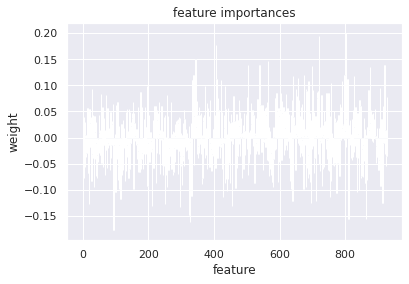

In [233]:
coef = model.coef_[0]

plt.bar(range(model.coef_.shape[-1]),model.coef_[0])
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')


### Essai avec PCA and best n components

Le x_correl est la meme que celui utilise pour le modele avec les masker, il faut modifier le code en-dessous pour aller chercher un autre x_correl.

train: 160 test: 40


100%|███████████████████████████████████████████| 15/15 [00:02<00:00,  6.02it/s]

[0.75, 0.60625, 0.66875, 0.68125, 0.7125, 0.725, 0.7, 0.725, 0.7125, 0.69375, 0.725, 0.73125, 0.73125, 0.725, 0.71875]


0

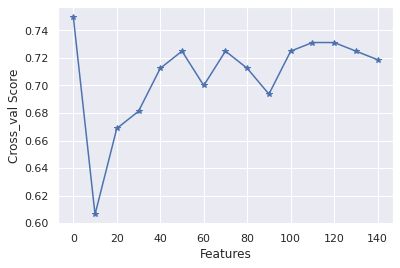

In [234]:
# split the sample o training/test with a 80/20 % ratio 
# and stratify sex by class, also shuffle the data

X_train, X_test, y_train, y_test = train_test_split( 
                                                    x_correl,  # x 
                                                    y_sex,       # y 
                                                    test_size = 0.2, # 80%/20% split 
                                                    shuffle = True,  #shuffle dataset before splitting
                                                    stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                    random_state = 123) #same shuffle each time 

print('train:', len(X_train),'test:', len(X_test))


# comparing different # of features for find how many explain the most variance 

score = []
max_feature = int(0.9*len(X_train))
n_components_range = range(0, max_feature, 10) # A range of different values for n_components

for n_comp in tqdm(n_components_range):
    if n_comp == 0:
        model = LinearSVC(max_iter=2000)
    else:
        model = Pipeline([
            ('feature_selection', PCA(n_comp)),
            ('prediction', LinearSVC(max_iter=2000))
                      ])
    #score = cross_val_score(model, X_train, y_train, cv=10)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())

    
print(score)
x = list(n_components_range)
plt.plot(x,score, color = "b", marker = "*")
plt.xlabel("Features")
plt.ylabel("Cross_val Score")

best_ncomp = n_components_range[np.array(score).argmax()]
best_ncomp


In [235]:
if best_ncomp == 0:
    model = LinearSVC(max_iter=2000)
else:
    model = Pipeline([
            ('feature_selection', PCA(best_ncomp)),
            ('prediction', LinearSVC(max_iter=2000))
                      ])

model.fit(X_train,y_train) #fit the model/ train the model
y_pred = model.predict(X_test)

#calculate the model accuracy
acc = model.score(X_test, y_test)

#compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
df = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
print(df.head())

# print results
print('accuracy (r2) =', acc)

# coef= model.coef_[0]
# coef_reshape = np.reshape(coef, (8, 193369))
# coef_reshape

       Positive  Negative
True         16         3
False         4        17
accuracy (r2) = 0.825
